In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os


zip_file_path = '/content/drive/My Drive/archive (3).zip'  # Adjust the path accordingly
destination_folder = '/content/Breast_ultrasound'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Extracted files to: {destination_folder}")


Extracted files to: /content/Breast_ultrasound


In [3]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class BreastUltrasoundDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []

        subfolders = ['benign', 'malignant', 'normal']
        for subfolder in subfolders:
            subfolder_path = os.path.join(root_dir, subfolder)
            for f in os.listdir(subfolder_path):
                if not f.endswith('_mask.png'):  # Collect only images, not masks
                    self.images.append(os.path.join(subfolder_path, f))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]

        base_filename = os.path.splitext(os.path.basename(img_path))[0]

        subfolder = os.path.dirname(img_path)
        mask_file = None

        for f in os.listdir(subfolder):
            if f.startswith(base_filename) and '_mask' in f:
                mask_file = f
                break

        if mask_file is None:
            raise FileNotFoundError(f"Mask file not found for image: {img_path}")

        mask_path = os.path.join(subfolder, mask_file)

        print(f"Image path: {img_path}")
        print(f"Mask path: {mask_path}")

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = BreastUltrasoundDataset(root_dir='/content/Breast_ultrasound/Dataset_BUSI_with_GT', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)


In [4]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
            return block

        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.encoder1 = conv_block(1, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = up_conv(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = up_conv(512, 256)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = up_conv(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = up_conv(128, 64)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder path
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder path
        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        out = self.final_conv(d1)
        return out


In [5]:
import torch.optim as optim
import torch.nn.functional as F

model = UNet()
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

def train_model(model, dataloader, optimizer, criterion, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in dataloader:
            images = images.cuda()
            masks = masks.cuda()

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

train_model(model, dataloader, optimizer, criterion, num_epochs=25)


Streaming output truncated to the last 5000 lines.
Image path: /content/Breast_ultrasound/Dataset_BUSI_with_GT/normal/normal (67).png
Mask path: /content/Breast_ultrasound/Dataset_BUSI_with_GT/normal/normal (67)_mask.png
Image path: /content/Breast_ultrasound/Dataset_BUSI_with_GT/benign/benign (64).png
Mask path: /content/Breast_ultrasound/Dataset_BUSI_with_GT/benign/benign (64)_mask.png
Image path: /content/Breast_ultrasound/Dataset_BUSI_with_GT/benign/benign (147).png
Mask path: /content/Breast_ultrasound/Dataset_BUSI_with_GT/benign/benign (147)_mask.png
Image path: /content/Breast_ultrasound/Dataset_BUSI_with_GT/benign/benign (163).png
Mask path: /content/Breast_ultrasound/Dataset_BUSI_with_GT/benign/benign (163)_mask_1.png
Image path: /content/Breast_ultrasound/Dataset_BUSI_with_GT/benign/benign (370).png
Mask path: /content/Breast_ultrasound/Dataset_BUSI_with_GT/benign/benign (370)_mask.png
Image path: /content/Breast_ultrasound/Dataset_BUSI_with_GT/benign/benign (233).png
Mask pa

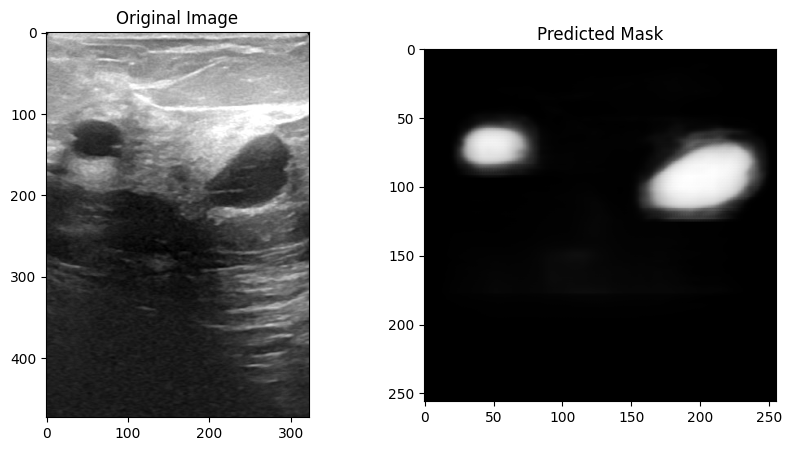

In [6]:
import matplotlib.pyplot as plt

def predict(model, image_path, transform):
    model.eval()

    image = Image.open(image_path).convert("L")
    image = transform(image).unsqueeze(0).cuda()

    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)
        output = output.squeeze().cpu().numpy()

    return output

image_path = '/content/Breast_ultrasound/Dataset_BUSI_with_GT/benign/benign (100).png'
predicted_mask = predict(model, image_path, transform)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path).convert("L"), cmap="gray")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Predicted Mask")
plt.show()
